In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%load_ext autoreload
%autoreload 2
import copy
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from learning_wavelets.data.datasets import im_dataset_bsd68
from learning_wavelets.models.dncnn import dncnn
from learning_wavelets.keras_utils.thresholding import SoftThresholding, HardThresholding, DynamicSoftThresholding, DynamicHardThresholding, RelaxedDynamicHardThresholding, LocalWienerFiltering
from learning_wavelets.models.learned_wavelet import learned_wavelet, learnlet
from learning_wavelets.models.learnlet_model import Learnlet
from learning_wavelets.models.unet import unet
from learning_wavelets.utils.metrics import metrics_from_ds, metrics_original_from_ds


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.4.1     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.2     installed
astropy        : >=3.0.0   - required | 3.2.3     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [4]:
np.random.seed(0)

In [5]:
all_net_params = [
]

def build_learnlet_subclassing(**run_params):
    model = Learnlet(**run_params)
    model.build([[None, None, None, 1], [None, 1]])
    return model

dynamic_denoising_net_params = [
    {
        'name': 'learnlet_0_55_big_bsd',
        'init_function': learnlet,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 256, 
                'mixing_details': False,  
                'kernel_size': 11,
                'skip_connection': True,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'n_scales': 5,
            'exact_reconstruction_weight': 0,
            'clip': True,
            'input_size': (None, None, 1),     
        },
        'run_id': 'learnlet_dynamic_st_bsd500_0_55_1580806694',
        'epoch': 500,
    },
    {
        'name': 'learnlet_0_55_reweights',
        'init_function': build_learnlet_subclassing,
        'run_params': {
            'denoising_activation': 'dynamic_soft_thresholding',
            'learnlet_analysis_kwargs':{
                'n_tiling': 64, 
                'mixing_details': False,    
                'skip_connection': True,
                'kernel_size': 11,
            },
            'learnlet_synthesis_kwargs': {
                'res': True,
                'kernel_size': 13,
            },
            'threshold_kwargs':{
                'noise_std_norm': True,
            },
            'n_scales': 5,
            'n_reweights_learn': 3,
            'clip': False,
        },
        'run_id': 'learnlet_subclassing_st_bsd500_0_55_1581766374',
        'epoch': 500,
    },  
]

In [6]:
noise_stds = [5, 15, 20, 25, 30, 50, 75]
# noise_stds = [15, 20, 30]
# noise_stds = [0.0001]

In [7]:
noise_std_metrics = {}
n_samples = None
for noise_std in tqdm_notebook(noise_stds, 'Noise stds'):
    metrics = []
    for net_params in all_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=False,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))
    im_ds = im_dataset_bsd68(
        mode='testing', 
        batch_size=1, 
        patch_size=None, 
        noise_std=noise_std, 
        return_noise_level=False,
        n_pooling=5,
        n_samples=n_samples,
    )
    metrics.append(('original', metrics_original_from_ds(im_ds)))
        
    for net_params in dynamic_denoising_net_params:
        im_ds = im_dataset_bsd68(
            mode='testing', 
            batch_size=1, 
            patch_size=None, 
            noise_std=noise_std, 
            return_noise_level=True,
            n_pooling=5,
            n_samples=n_samples,
        )
        metrics.append((net_params['name'], metrics_from_ds(im_ds, **net_params)))

#     metrics.append(('bm3d', metrics_bm3d(im_gen_test)))
#     metrics.append(('wavelets_24', metrics_wavelets(im_gen_test, '24', noise_std=noise_std)))
#     metrics.sort(key=lambda x: x[1].metrics['PSNR'].mean())
    noise_std_metrics[noise_std] = metrics

/volatile/home/Zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=1)
/volatile/home/Zaccharie/workspace/understanding-unets/learning_wavelets/evaluate.py:43: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  gt, pred, multichannel=True, data_range=1


In [8]:
noise_std_metrics

{5: [('original', PSNR = 34.16 +/- 0.02807 SSIM = 0.8856 +/- 0.1019),
  ('learnlet_0_55_big_bsd', PSNR = 36.39 +/- 4.073 SSIM = 0.9569 +/- 0.03059),
  ('learnlet_0_55_reweights',
   PSNR = 36.83 +/- 3.639 SSIM = 0.9594 +/- 0.02689)],
 15: [('original', PSNR = 24.61 +/- 0.0302 SSIM = 0.5689 +/- 0.2587),
  ('learnlet_0_55_big_bsd', PSNR = 30.83 +/- 4.74 SSIM = 0.8586 +/- 0.09609),
  ('learnlet_0_55_reweights',
   PSNR = 30.94 +/- 4.666 SSIM = 0.8637 +/- 0.09263)],
 20: [('original', PSNR = 22.11 +/- 0.0303 SSIM = 0.4661 +/- 0.266),
  ('learnlet_0_55_big_bsd', PSNR = 29.48 +/- 4.865 SSIM = 0.8155 +/- 0.1101),
  ('learnlet_0_55_reweights',
   PSNR = 29.58 +/- 4.844 SSIM = 0.8213 +/- 0.1096)],
 25: [('original', PSNR = 20.17 +/- 0.02714 SSIM = 0.3883 +/- 0.2565),
  ('learnlet_0_55_big_bsd', PSNR = 28.47 +/- 4.9 SSIM = 0.7757 +/- 0.1195),
  ('learnlet_0_55_reweights', PSNR = 28.57 +/- 4.94 SSIM = 0.7833 +/- 0.1205)],
 30: [('original', PSNR = 18.59 +/- 0.02905 SSIM = 0.328 +/- 0.2399),
  ('l

In [9]:
BM3D_psnr_results = {
    5: 37.57,
    15: 31.07,
    20: 29.60,
    25: 28.57,
    30: 27.74,
    50: 25.62,
    75: 24.21,
}

wavelets_psnr_results = {
    5: (35.76,  1.937),
    15: (29.56,  2.553),
    20: (28.25,  2.645),
    25: (27.32,  2.684),
    30: (26.61,  2.694),
    50: (24.79,  2.673),
    75: (23.46,  2.574),
}

In [10]:
# PSNR table
psnr_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    psnr_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        psnr_metrics_table.loc[i, name] = "{mean:.4} ({std:.2})".format(
            mean=m.metrics['PSNR'].mean(), 
            std=m.metrics['PSNR'].stddev(),
        )
#     psnr_metrics_table.loc[i, 'bm3d'] = BM3D_psnr_results[noise_std]
#     psnr_metrics_table.loc[i, 'wavelets_24'] = "{mean:.4} ({std:.2})".format(
#         mean=wavelets_psnr_results[noise_std][0], 
#         std=wavelets_psnr_results[noise_std][1],
#     )
psnr_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_reweights,original,wavelets_24,bm3d
0,5,36.39 (2.0),36.83 (1.8),34.16 (0.014),NaN,NaN
1,15,30.83 (2.4),30.94 (2.3),24.61 (0.015),NaN,NaN
2,20,29.48 (2.4),29.58 (2.4),22.11 (0.015),NaN,NaN
3,25,28.47 (2.5),28.57 (2.5),20.17 (0.014),NaN,NaN
4,30,27.67 (2.5),27.76 (2.5),18.59 (0.015),NaN,NaN
5,50,25.48 (2.4),25.61 (2.4),14.15 (0.017),NaN,NaN
6,75,23.78 (2.2),23.94 (2.3),10.63 (0.016),NaN,NaN


In [11]:
# SSIM table
ssim_metrics_table = pd.DataFrame(
    columns=['noise_std'] + [p['name'] for p in all_net_params] + [p['name'] for p in dynamic_denoising_net_params] + ['original', 'wavelets_24', 'bm3d'],
)
for i, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    ssim_metrics_table.loc[i, 'noise_std'] = noise_std
    for name, m in metrics:
        ssim_metrics_table.loc[i, name] = "{mean:.4} ({std:.4})".format(
            mean=m.metrics['SSIM'].mean(), 
            std=m.metrics['SSIM'].stddev(),
        )
ssim_metrics_table

,noise_std,learnlet_0_55_big_bsd,learnlet_0_55_reweights,original,wavelets_24,bm3d
0,5,0.9569 (0.01529),0.9594 (0.01344),0.8856 (0.05096),NaN,NaN
1,15,0.8586 (0.04804),0.8637 (0.04632),0.5689 (0.1293),NaN,NaN
2,20,0.8155 (0.05503),0.8213 (0.05478),0.4661 (0.133),NaN,NaN
3,25,0.7757 (0.05975),0.7833 (0.06027),0.3883 (0.1283),NaN,NaN
4,30,0.7402 (0.06261),0.7479 (0.06424),0.328 (0.12),NaN,NaN
5,50,0.619 (0.06705),0.6332 (0.07084),0.1834 (0.08348),NaN,NaN
6,75,0.506 (0.06412),0.5262 (0.06908),0.1014 (0.0516),NaN,NaN


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set(style="whitegrid", palette="muted", rc={'figure.figsize': (9, 5), 'image.cmap': 'gray'})

In [14]:
relative_to_original = True

model_family_str = r'$\bf{Model}$'
train_stds_str = r'$\bf{Train}$  $\bf{std}$'
noise_std_str = 'Test noise standard deviation'
psnr_str = 'Ratio over original PSNR'
# PSNR to plot
psnr_to_plot = pd.DataFrame(
    columns=[noise_std_str, psnr_str, 'psnr-std-dev', 'model_name', model_family_str, train_stds_str]
)

def from_name_to_family(model_name):
    if 'learnlet' in model_name:
        return 'Learnlets'
    elif 'unet' in model_name:
        return 'U-net'
    elif 'bm3d' in model_name:
        return 'BM3D'
    elif 'wavelets' in model_name:
        return 'Wavelets'
    else:
        return 'Original'
    
def from_name_to_train_stds(model_name):
    if '30' in model_name:
        return '30'
    elif '20_40' in model_name:
        return '[20; 40]'
    else:
        return '[0; 55]'

family_model_to_color = {
    'U-net': (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
    'Learnlets': (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
    'BM3D': 'violet',
    'Wavelets': 'red',
    'Original': (0.41568627450980394, 0.8, 0.39215686274509803),
}
index = 0
orig_psnrs = {}
for i_noise, (noise_std, metrics) in enumerate(noise_std_metrics.items()):
    for j_model, (name, m) in enumerate(metrics):
        if relative_to_original and name == 'original':
            orig_psnrs[noise_std] = m.metrics['PSNR'].mean()
        else:
            psnr_to_plot.loc[index, noise_std_str] = noise_std
            psnr_to_plot.loc[index, psnr_str] = m.metrics['PSNR'].mean()
            psnr_to_plot.loc[index, 'psnr-std-dev'] = m.metrics['PSNR'].stddev() / 2
            psnr_to_plot.loc[index, 'model_name'] = name
            psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
            psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
            index += 1
#     name = 'bm3d'
#     psnr_to_plot.loc[index, noise_std_str] = noise_std
#     psnr_to_plot.loc[index, psnr_str] = BM3D_psnr_results[noise_std]
#     psnr_to_plot.loc[index, 'psnr-std-dev'] = 0
#     psnr_to_plot.loc[index, 'model_name'] = name
#     psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
#     psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
#     index += 1
#     name = 'wavelets_24'
#     psnr_to_plot.loc[index, noise_std_str] = noise_std
#     psnr_to_plot.loc[index, psnr_str] = wavelets_psnr_results[noise_std][0]
#     psnr_to_plot.loc[index, 'psnr-std-dev'] = wavelets_psnr_results[noise_std][1]
#     psnr_to_plot.loc[index, 'model_name'] = name
#     psnr_to_plot.loc[index, train_stds_str] = from_name_to_train_stds(name)
#     psnr_to_plot.loc[index, model_family_str] = from_name_to_family(name)
#     index += 1
    

if relative_to_original:
    for noise_std, orig_psnr in orig_psnrs.items():
        psnr_to_plot.loc[psnr_to_plot[noise_std_str] == noise_std, psnr_str] = psnr_to_plot[psnr_to_plot[noise_std_str] == noise_std][psnr_str] / orig_psnr
    
psnr_to_plot

,Test noise standard deviation,Ratio over original PSNR,psnr-std-dev,model_name,$\bf{Model}$,$\bf{Train}$ $\bf{std}$
0,5,1.06533,1.01836,learnlet_0_55_big_bsd,Learnlets,[0; 55]
1,5,1.07837,0.909629,learnlet_0_55_reweights,Learnlets,[0; 55]
2,15,1.2529,1.185,learnlet_0_55_big_bsd,Learnlets,[0; 55]
3,15,1.25711,1.16641,learnlet_0_55_reweights,Learnlets,[0; 55]
4,20,1.33357,1.21626,learnlet_0_55_big_bsd,Learnlets,[0; 55]
5,20,1.33771,1.21099,learnlet_0_55_reweights,Learnlets,[0; 55]
6,25,1.41124,1.22501,learnlet_0_55_big_bsd,Learnlets,[0; 55]
7,25,1.41639,1.23505,learnlet_0_55_reweights,Learnlets,[0; 55]
8,30,1.48861,1.23048,learnlet_0_55_big_bsd,Learnlets,[0; 55]
9,30,1.49378,1.23901,learnlet_0_55_reweights,Learnlets,[0; 55]


In [15]:
# plt.figure()
# psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
# lplot = sns.lineplot(
#     x=noise_std_str, 
#     y=psnr_str, 
#     hue=model_family_str,
#     style=train_stds_str,
#     data=psnr_to_plot,
#     palette=family_model_to_color,
# )
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
# plt.subplots_adjust(right=0.83)
# plt.savefig(f'gen.png')

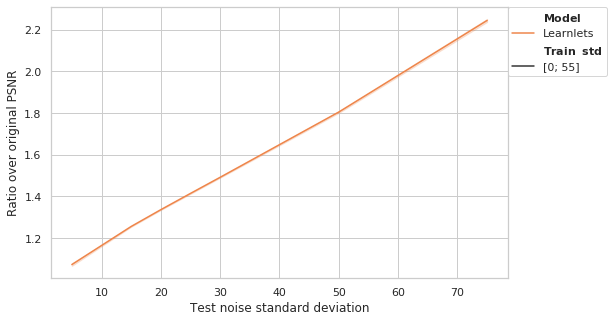

In [16]:
plt.figure()
psnr_to_plot[psnr_str] = psnr_to_plot[psnr_str].astype(float)
lplot = sns.lineplot(
    x=noise_std_str, 
    y=psnr_str, 
    hue=model_family_str,
    style=train_stds_str,
    data=psnr_to_plot,
    palette=family_model_to_color,
)
# lplot.errorbar(
#     x=noise_std_str, 
#     y=psnr_str,
#     yerr='psnr-std-dev',
#     fmt='none',
#     ecolor=[family_model_to_color[mf] for mf in psnr_to_plot[model_family_str]],
#     data=psnr_to_plot,
#     alpha=0.3,
#     label=None,
# )
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best', borderaxespad=0)
plt.subplots_adjust(right=0.83)
plt.savefig(f'gen_wo_error_bars.png')